# Initial Setup

In a first step we collect all the graphs we need for some given pattern. For this we overapproximate the set of graphs in the spasm by simply taking all graphs with less vertices and less or equal number of edges. 
This forms the spasm space, for this space we compute the homomorphism basis (most of them usually will have coefficient 0, i.e., they aren't in the basis and will thus be ignored going forward).

In [14]:
from pact.hombase import hombase_coeffs_nauty
from pact.spasmspace import SpasmSpace
from pact.graphwrapper import GraphWrapper
from pact.ui import default_progressbar

import dill
import os
import networkx as nx
import multiprocess as mp

import math

_MIN_TW_INJECT = 1 # lowest tw for which homs are created
THREADS = 3
CYCLE_LEN = 8
BASIS_PATH = 'gnnstuff/bases/'
if not os.path.exists(BASIS_PATH):
    os.makedirs(BASIS_PATH)

BASIS_FILE = f'{BASIS_PATH}/cycle{CYCLE_LEN}_basis.json'


# change here if we're not doing cycles, this is the pattern that we're using the subgraph basis of
nxP = nx.cycle_graph(CYCLE_LEN)

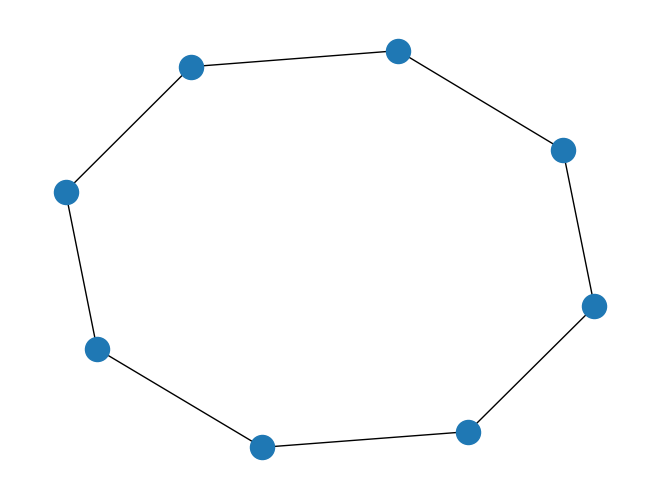

In [15]:

P = GraphWrapper(nxP)

spsp = SpasmSpace()
Pbasis = hombase_coeffs_nauty(P, spsp, expand_space=True)
spsp.cleanup_for_storage()

nx.draw(P.graph)

# Preprocessing for patterns in basis

To actually count the homomormphisms we comptue tree decompositions of all graphs in the basis. From those tree decompositions we create cexecution plans (the `plan` attribute).

In [16]:
from pact.balgowrapper import balgo_multitry_for_cheapest_decomp
from pact.planner import node_to_ops, node_to_ops_earlysj
from pact.treedecomp import td_nodes_it

_MARK_VTX = 0


def find_v_in_childbag(td, v):
    for u in td_nodes_it(td):
        for c in u.children:
            if v in c.bag:
                return u,c
    return None

def find_parent(td, c):
    for u in td_nodes_it(td):
        if c in u.children:
            return u
    return None
            
def guarantee_v_in_root(td, v):
    if v in td.bag:
        return td
    p, c = find_v_in_childbag(td, v)
    newroot = c
    
    while p is not None:
        # delete c from p.children, add p into c.children
        p.children.remove(c)
        c.children.append(p)
        
        # repeat upwards
        c = p
        p = find_parent(td, c)
    return newroot

for fid in Pbasis.keys():
    F = spsp[fid]
    decomp, badness = balgo_multitry_for_cheapest_decomp(F, times=20, threads=THREADS)
    
    # we change the root of the decomposition to guarantee that vertex with label _MARK_VTX is
    # in the root (this is to guarantee consistent vertex-level counts, 
    # i.e., for each v we count homs(P,G)[_MARK_VTX -> v])
    decomp = guarantee_v_in_root(decomp, _MARK_VTX)
    F.td = decomp
    F.td_badness = badness

    F.plan = node_to_ops_earlysj(F.td)

In [17]:
spsp.cleanup_for_storage()
toserialise = {'SpasmSpace': spsp, 'basis': Pbasis}

with open(BASIS_FILE, 'wb') as f:
    f.write(dill.dumps(toserialise))